In [92]:
import sys
sys.path.append( "..\\.")

import pylab
import numpy
import scipy
from   scipy import fftpack
from   scipy.fftpack import fft, ifft, hilbert, fftshift, rfft 
import os
import nmrglue
import twoDplot_1 as twoDplot
import ist

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

In [93]:
from scipy import pi

In [94]:
f1=300
zerofill = 512
f2=512
pp=16
pp_from = 32

max_num_peaks = 100
tolerance = 110
iterations = 200

In [95]:
expt_no = "20"  

directory = os.path.join("..","bruker_data","eeh_20160508" ) # work

file_rrr = os.path.join( directory, expt_no, "pdata", "1")

file_ser = os.path.join(directory,expt_no)
                         
cs_file  = os.path.join( directory,expt_no,"vdlist")
file1    = os.path.join( directory,expt_no,"pdata","1","2rr" )

shape (300, 512.0)
76.3746223004
[]


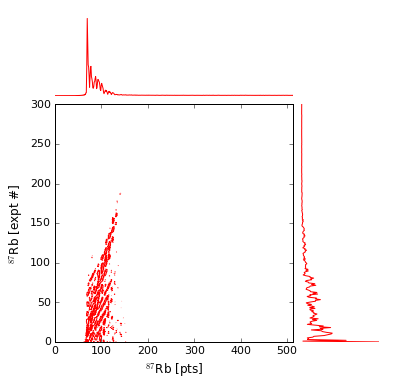

In [96]:
pinfo,expt = nmrglue.bruker.read_pdata( file_rrr )
info,expt_fid = nmrglue.bruker.read( file_ser )

ppplot = twoDplot.TwoD_NMR_MAT_plot( expt_fid.real, pinfo, info, axis_domains = ['t','t'])
ppplot.display_plot()

In [97]:
si1 = 512
si2 = 512
xdim1 = 512
xdim2 = 512
tdeff1 = 300

f1shift = 0
sfo1    = info['acqu2s']["SFO1"]

ratio = 7./9.

swh1 =  pinfo['procs' ]['SW_p']
swh2     = pinfo['proc2s' ]['SW_p']

print swh1,swh2,sfo1

10000 10000 494.641221556


In [98]:
ph1 = pi * ratio * swh2 / swh1 / si2
phc2 = -pi * f1shift * sfo1 / swh1;

In [99]:
print ph1,phc2

0.00477238467342 -0.0


76.3746223004
[]


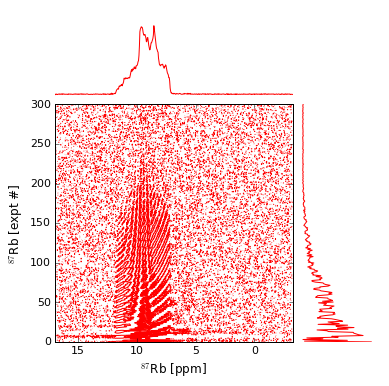

In [100]:
# Fourier Transform in F2 dimension and phase

spec = fftpack.fft(expt_fid, axis=1)
spec = fftpack.fftshift(spec, axes=1)

spec = nmrglue.process.proc_base.ps(spec, p0=-pinfo['procs']['PHC0']+7.0, p1=info['acqus']['GRPDLY']*360.0-pinfo['procs']['PHC1'], inv=False)


ppplot = twoDplot.TwoD_NMR_MAT_plot( spec.real, pinfo, info, axis_domains=['w','t'])
ppplot.display_plot()

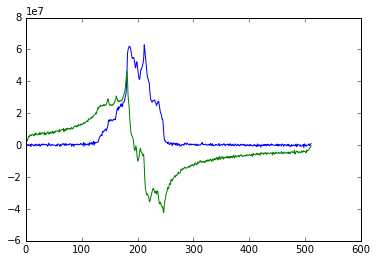

In [101]:
pylab.plot(spec[0].real);
pylab.plot(spec[0].imag);

In [102]:
print spec.shape

(300L, 512L)


In [103]:
# Shear the fid based on the spin number

"""	for (loopcount4 = 0; loopcount4 < xdim2; loopcount4++)
	{
	  double ev = in2rr[loopcount4];
	  double od = in2rr[loopcount4 + xdim2];
	  double ph = (ph1 * (loopcount2 + loopcount4) + phc2) * loopcount3;
	  double co = cos(ph);
	  double si = sin(ph);

/* perform shearing transformation
   =============================== */
	  in2rr[loopcount4]	    = (int)(ev * co + od * si);
	  in2rr[loopcount4 + xdim2] = (int)(od * co - ev * si);
	}"""

sheared_expt = scipy.zeros((si1,si2), dtype=scipy.complex128)
jjj = scipy.arange(xdim2)
    
k=0
for i in range(0,tdeff1,2):

        ev = spec[i].real
        od = spec[i+1].real
        ph = ph1 * jjj * i
        
        co = scipy.cos(ph)
        si = scipy.sin(ph)
        
        sheared_expt[k] =  (ev*co+od*si) + 1j* (od*co-ev*si )
        k +=1

76.3746223004
[]


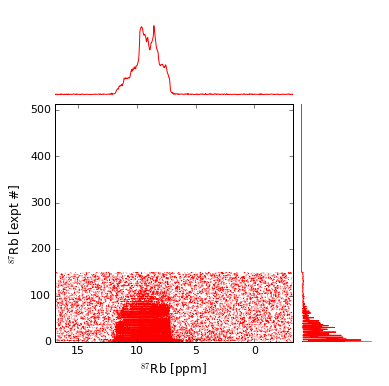

In [104]:
ppplot = twoDplot.TwoD_NMR_MAT_plot( sheared_expt.real, pinfo, info, axis_domains=['w','t'],contourlevels_range=[0.01,0.8])
ppplot.display_plot()

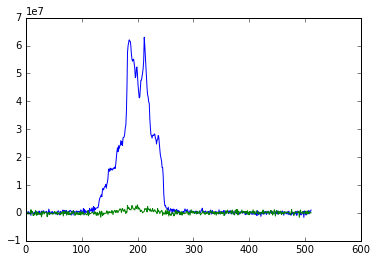

In [105]:
pylab.plot(sheared_expt[0].real);
pylab.plot(sheared_expt[0].imag);

76.3746223004
[100, 0, 16, 0]


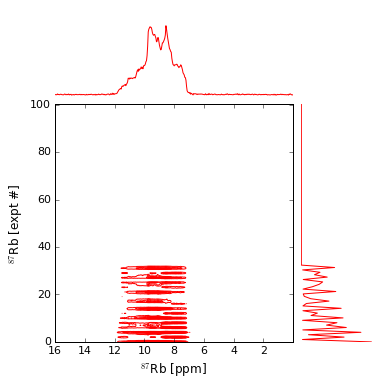

In [106]:
# Zero certain rows based on compressed sensing values
for fid in sheared_expt[pp_from:]:
    fid *= 0.0
ppplot = twoDplot.TwoD_NMR_MAT_plot( sheared_expt.real, pinfo, info, axis_domains=['w','t'],dimensions_ppm=[100,0,16,0],contourlevels_range=[0.04,0.8])
ppplot.display_plot()

In [107]:
sss_spec = fftpack.fft(sheared_expt, axis=0)

In [108]:
#sss_spec = fftpack.fftshift(sss_spec, axes=0)

76.3746223004
[]


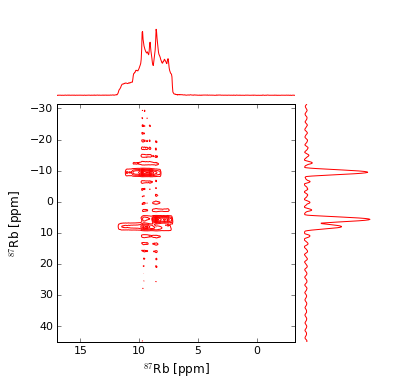

In [109]:
#Display FFT of full data
ppplot = twoDplot.TwoD_NMR_MAT_plot( sss_spec.real, pinfo, info, contourlevels_range=[0.05,1.1],  axis_domains=['w','w'])
ppplot.display_plot()

0 23
1 13
2 14
3 1
4 30
5 11
6 24
7 3
8 9
9 8
10 16
11 25
12 2
13 22
14 0
15 17
76.3746223004
[]


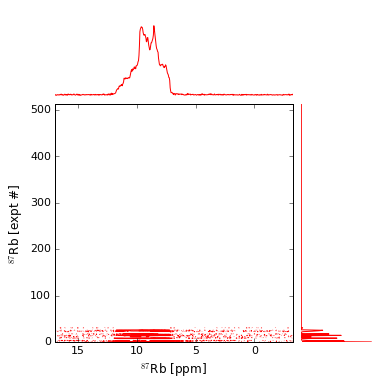

In [110]:
# Create real and imag data arrays and put fids in correct position and order

rrr =scipy.zeros((zerofill,f2), dtype=numpy.int32)
iii =scipy.zeros((zerofill,f2), dtype=numpy.int32)

prm   = numpy.random.permutation(pp_from)
#prm = numpy.array([0,31,2,10,11,24,1,15,27,21,12,9,5,2,19,14])
#prm = numpy.array([0,27,54,10,32,51,50,31,6,25,14,22,60,52,45,62,21,49,33,20,5,59,34,38,13,3,8,35,11,18,30,55])
cs_array = prm[:pp]

numpts = zerofill
mask = numpy.zeros(numpts, dtype=numpy.float32)

for i in cs_array:
    mask[i] = 1.0
    
for i,v in enumerate(cs_array):
    print i,v
    rrr[v] = rrr[v]+sheared_expt[v].real
    iii[v] = iii[v]+sheared_expt[v].imag
    


ppplot = twoDplot.TwoD_NMR_MAT_plot( rrr, pinfo, info, axis_domains=['w','t'])
ppplot.display_plot()

In [111]:
fid = rrr+1j*iii

76.3746223004
[]


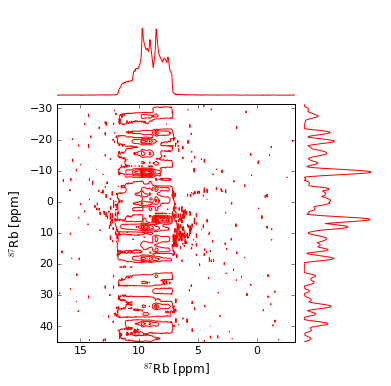

In [112]:
#Display 2-D FFT data of zeroed data set
sss = spec = fftpack.fft(fid, axis=0)
#sss = fftpack.fftshift(sss, axes=0)

ppplot = twoDplot.TwoD_NMR_MAT_plot( sss.real, pinfo, info, axis_domains=['w','w'])
ppplot.display_plot()

76.3746223004
[]


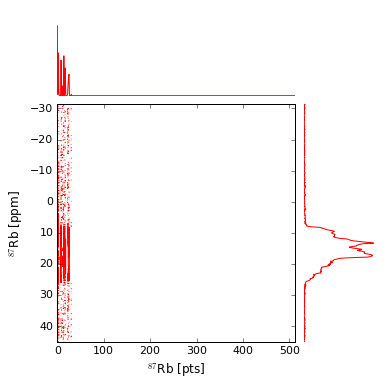

In [113]:
# find the maximum index value in the first spectrum. Value used in he thresh-holding algorihm

mp =rrr[0].argmax()
rrr = rrr.transpose()
iii = iii.transpose()

mmm_t = (rrr + 1j*iii)

ppplot = twoDplot.TwoD_NMR_MAT_plot( mmm_t.real, pinfo, info,  axis_domains=['t','w'])
ppplot.display_plot()

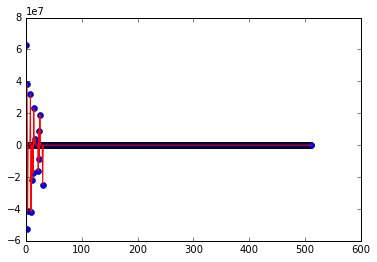

In [114]:
pylab.plot( mask*mmm_t[mp].real, 'o' );
pylab.plot( mmm_t[mp].real, 'r-' );

In [115]:
# Perform thresholding in T1 for each point

cs_spec = scipy.zeros((f2,zerofill), dtype=numpy.complex128)

stats_array = []

for j in range(f2):
    print j,

    Y, stats = ist.compressed_sensing_1VD1d( mmm_t[j], mask, num_iter=1000, maxPeaks=200, peak_separation=1000, tolerance=1e-4 )
    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))
    
    stats_array.append(stats)

0 reached max iterations
1 reached max iterations
2 reached max iterations
3 reached max iterations
4 5 reached max iterations
6 reached max iterations
7 reached max iterations
8 reached max iterations
9 reached max iterations
10 11 reached max iterations
12 13 reached max iterations
14 reached max iterations
15 16 reached max iterations
17 reached max iterations
18 reached max iterations
19 reached max iterations
20 reached max iterations
21 reached max iterations
22 reached max iterations
23 reached max iterations
24 reached max iterations
25 reached max iterations
26 reached max iterations
27 reached max iterations
28 reached max iterations
29 reached max iterations
30 reached max iterations
31 reached max iterations
32 reached max iterations
33 reached max iterations
34 35 reached max iterations
36 reached max iterations
37 reached max iterations
38 39 reached max iterations
40 reached max iterations
41 42 reached max iterations
43 reached max iterations
44 reached max iterations
4

In [116]:
#for m in range(f2):
#    cs_spec[m] = fftpack.fftshift(cs_spec[m])

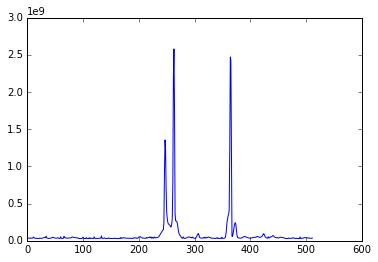

In [117]:
# Display high resolution projection 

cs_spec_sum1 = (cs_spec.real).sum(axis=1) 
#print cs_spec_sum1.max(), (cs_spec_sum[:]).sum()
ssum0 = (cs_spec.real).sum(axis=0)

pylab.plot( (cs_spec.real).max(axis=0) );


In [118]:
spec = fftpack.fft(mmm_t, axis=1)

In [119]:
cs_spec_real = (cs_spec.real/10000.0)

In [120]:
cs_spec_int32 = scipy.array(cs_spec_real, dtype=scipy.int32)

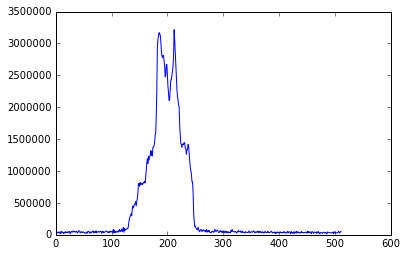

In [121]:
pylab.plot(((cs_spec_int32).sum(axis=1)));

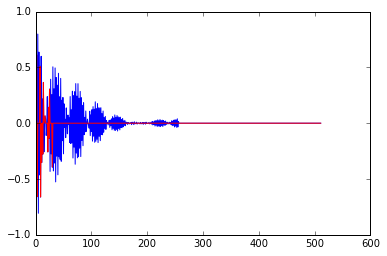

In [122]:
pylab.plot( fftpack.ifft(cs_spec[mp]).real/(fftpack.ifft(cs_spec[mp]).real).max() );
pylab.plot( mmm_t[mp].real/(mmm_t[mp].real).max(), 'r-' );

In [123]:
# Arrange 2-D spectrum  in correct order for display with Bruker Topsin

cs_spec_int32 = cs_spec_int32.transpose()
cs_spec_int32 = numpy.fliplr(cs_spec_int32)
cs_spec_int32 = numpy.flipud(cs_spec_int32)

In [124]:
expt = cs_spec_real
expt = expt.transpose()

76.3746223004
[]


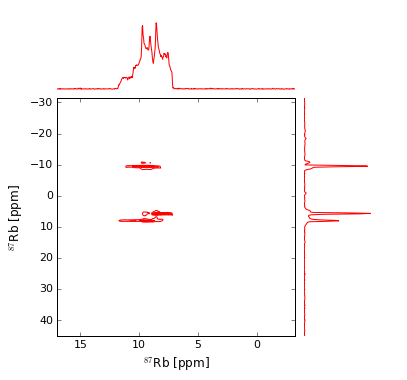

In [137]:
ppplot = twoDplot.TwoD_NMR_MAT_plot( expt, pinfo, info, axis_domains=['w','w'],contourlevels_range=[0.075,1.1])
ppplot.display_plot()

76.3746223004
[-20, 0, 15, 5]


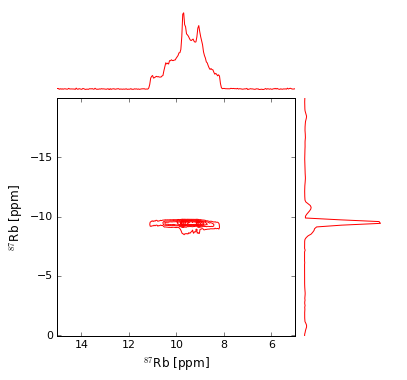

In [135]:
ppplot = twoDplot.TwoD_NMR_MAT_plot( expt, pinfo, info, dimensions_ppm=[-20,0,15,5], axis_domains=['w','w'],contourlevels_range=[0.1,1.1])
ppplot.display_plot()

76.3746223004
[6.8, 10, 15, 5]


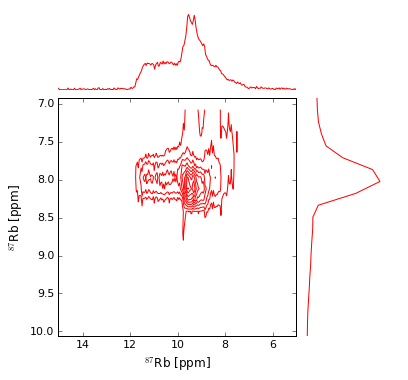

In [134]:
ppplot = twoDplot.TwoD_NMR_MAT_plot( expt, pinfo, info, dimensions_ppm=[6.8,10,15,5], axis_domains=['w','w'],contourlevels_range=[0.1,1.1])
ppplot.display_plot()

76.3746223004
[3, 6.8, 15, 5]


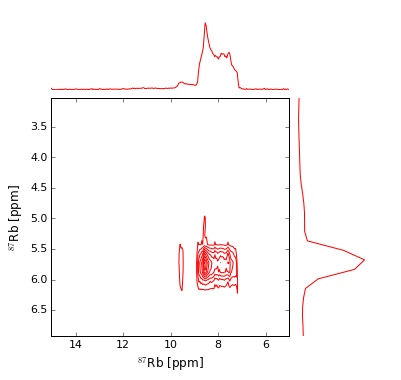

In [132]:
ppplot = twoDplot.TwoD_NMR_MAT_plot( expt, pinfo, info, dimensions_ppm=[3,6.8,15,5], axis_domains=['w','w'],contourlevels_range=[0.1,1.1])
ppplot.display_plot()

In [133]:
dir(ist)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'compressed_sensing_1VD',
 'compressed_sensing_1VD1b',
 'compressed_sensing_1VD1c',
 'compressed_sensing_1VD1d',
 'fft',
 'fftpack',
 'fftshift',
 'hilbert',
 'ifft',
 'numPeaks',
 'numpy']